In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import pickle
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, MinMaxScaler,normalize
sns.set()

In [6]:
def process_data(file, lags):
    """Process data
    Reshape and split train\test data.
    # Arguments
        train: String, name of .csv train file.
        test: String, name of .csv test file.
        lags: integer, time lag.
    # Returns
        X_train: ndarray.
        y_train: ndarray.
        X_test: ndarray.
        y_test: ndarray.
        scaler: StandardScaler.
    """
    
#     read csv file
    df = pd.read_csv("/Users/ditlswin/Documents/rkaul/traffic_flow_predi/TrafficFlowPrediction-master/data/{}".format(file), encoding='utf-8',header=None).fillna(0)

#   read all the vehicle/15min in one array   
    flow = np.array(df.iloc[:,3:])
    flow = flow.ravel()

    
#     normalize all the values  
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(flow.reshape(-1, 1))
    normalized_flow = scaler.transform(flow.reshape(-1, 1)).reshape(1, -1)[0]
    

#     splitting the file into train and test dataset
    split = int(normalized_flow.shape[0] * 0.8)
    
    flow1 = normalized_flow[:split]
    flow2 = normalized_flow[split:]
    
    
    train, test = [], []
    for i in range(lags, len(flow1)):
        train.append(flow1[i - lags: i + 1])
    for i in range(lags, len(flow2)):
        test.append(flow2[i - lags: i + 1])

    train = np.array(train)
    test = np.array(test)
    np.random.shuffle(train)

    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_test = test[:, :-1]
    y_test = test[:, -1]

    return X_train, y_train, X_test, y_test, scaler

In [7]:
file = "970_1_data.csv"
lags = 12
X_train, y_train, X_test, y_test, scaler = process_data(file, lags)

In [11]:
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

rmse_val = [] #to store rmse values for different k
for K in range(25):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train, y_train)  #fit the model
    pred=model.predict(X_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 0.06818911040341162
RMSE value for k=  2 is: 0.0563491642396077
RMSE value for k=  3 is: 0.05379577125380491
RMSE value for k=  4 is: 0.051575317971021176
RMSE value for k=  5 is: 0.05119863130780938
RMSE value for k=  6 is: 0.05030116283676832
RMSE value for k=  7 is: 0.050244783691162274
RMSE value for k=  8 is: 0.04981418945606994
RMSE value for k=  9 is: 0.04967841769421181
RMSE value for k=  10 is: 0.049493918606524356
RMSE value for k=  11 is: 0.04898911369818478
RMSE value for k=  12 is: 0.04904074174560658
RMSE value for k=  13 is: 0.04921088002292766
RMSE value for k=  14 is: 0.04970726933656437
RMSE value for k=  15 is: 0.0499816434725535
RMSE value for k=  16 is: 0.04988989864839339
RMSE value for k=  17 is: 0.049996069147947596
RMSE value for k=  18 is: 0.04999598300400021
RMSE value for k=  19 is: 0.05011208522140469
RMSE value for k=  20 is: 0.050092027393133856
RMSE value for k=  21 is: 0.04989805928101102
RMSE value for k=  22 is: 0.049894826545

In [14]:
pickle.dump(model, open("knn.model", 'wb'))

In [15]:
pred=model.predict(X_test)

In [16]:
predicted = scaler.inverse_transform(pred.reshape(-1, 1)).reshape(1, -1)[0]

In [17]:
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

In [27]:
file = "970_1_data.csv"
lags = 12
X_train, y_train, X_test, y_test, scaler = process_data(file, lags)

param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'mae'

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

evallist = [(dtest, 'eval'), (dtrain, 'train')]

num_round = 100
model_xgb = xgb.train(param, dtrain, num_round,evallist)

model_xgb.save_model('xgb.model')

dtest = xgb.DMatrix(X_test)
ypred = model_xgb.predict(dtest)

[0]	eval-mae:0.077077	train-mae:0.077581
[1]	eval-mae:0.059037	train-mae:0.058109
[2]	eval-mae:0.05276	train-mae:0.050829
[3]	eval-mae:0.051493	train-mae:0.048636
[4]	eval-mae:0.048148	train-mae:0.044877
[5]	eval-mae:0.047856	train-mae:0.044154
[6]	eval-mae:0.046106	train-mae:0.04283
[7]	eval-mae:0.046079	train-mae:0.042505
[8]	eval-mae:0.044917	train-mae:0.04154
[9]	eval-mae:0.044639	train-mae:0.041113
[10]	eval-mae:0.043932	train-mae:0.040488
[11]	eval-mae:0.043701	train-mae:0.040076
[12]	eval-mae:0.043785	train-mae:0.039666
[13]	eval-mae:0.04318	train-mae:0.039234
[14]	eval-mae:0.043058	train-mae:0.039064
[15]	eval-mae:0.043072	train-mae:0.038841
[16]	eval-mae:0.043038	train-mae:0.03841
[17]	eval-mae:0.042505	train-mae:0.038066
[18]	eval-mae:0.04229	train-mae:0.037958
[19]	eval-mae:0.041936	train-mae:0.037828
[20]	eval-mae:0.041911	train-mae:0.037554
[21]	eval-mae:0.04179	train-mae:0.037184
[22]	eval-mae:0.041871	train-mae:0.03694
[23]	eval-mae:0.042104	train-mae:0.036863
[24]	eval-

/Users/ditlswin/anaconda3/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


[32]	eval-mae:0.041815	train-mae:0.034933
[33]	eval-mae:0.041736	train-mae:0.034827
[34]	eval-mae:0.041695	train-mae:0.034699
[35]	eval-mae:0.041665	train-mae:0.03463
[36]	eval-mae:0.041838	train-mae:0.034439
[37]	eval-mae:0.041834	train-mae:0.034304
[38]	eval-mae:0.041854	train-mae:0.034194
[39]	eval-mae:0.041804	train-mae:0.033991
[40]	eval-mae:0.041817	train-mae:0.033976
[41]	eval-mae:0.041904	train-mae:0.033826
[42]	eval-mae:0.041878	train-mae:0.033789
[43]	eval-mae:0.041733	train-mae:0.03366
[44]	eval-mae:0.041777	train-mae:0.033525
[45]	eval-mae:0.041591	train-mae:0.033422
[46]	eval-mae:0.041434	train-mae:0.033346
[47]	eval-mae:0.041547	train-mae:0.033172
[48]	eval-mae:0.04163	train-mae:0.033086
[49]	eval-mae:0.041633	train-mae:0.032961
[50]	eval-mae:0.041627	train-mae:0.032932
[51]	eval-mae:0.041346	train-mae:0.032747
[52]	eval-mae:0.041341	train-mae:0.03268
[53]	eval-mae:0.041376	train-mae:0.032534
[54]	eval-mae:0.041362	train-mae:0.032484
[55]	eval-mae:0.041383	train-mae:0.032

In [24]:
pred = scaler.inverse_transform(ypred.reshape(-1, 1)).reshape(1, -1)[0]

In [25]:
y_test1 = scaler.inverse_transform(y_test.reshape(-1, 1)).reshape(1, -1)[0]

/Users/ditlswin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


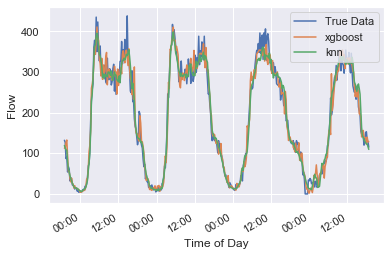

In [26]:
import matplotlib as mpl
d = '2006-10-25 19:00'
x = pd.date_range(d, periods=384, freq='15min')

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x, y_test1[:384], label='True Data')

ax.plot(x, pred[:384], label="xgboost")
ax.plot(x, predicted[:384], label="knn")

plt.legend()
plt.grid(True)
plt.xlabel('Time of Day')
plt.ylabel('Flow')

date_format = mpl.dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

plt.show()